## Dataset generation from deformable mirror and GRIN fiber

In [70]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber
from mmfsim.datasets import SimulatedGrinSpeckleOutputDataset
from mmfsim.transforms import fourier_transform

from speckleret.metrics import quality, pearson

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
grid = Grid(pixel_size=0.5e-6, pixel_numbers=(128,128))
fiber = GrinFiber(radius=26e-6, wavelength=1064e-9, n1=1.465, n2=1.45)
print(fiber)
coupling_matrix = fiber.modes_coupling_matrix(complex=complex, full=False, degen=True)

GrinFiber instance with:
  - Radius: 26.0 um
  - Core index: 1.465
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.209
  - Number of guided LP modes: 64
  - Number of guided LP modes (counting degenerates): 113
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[1.465      0.         0.         1.        ]
 [1.46407036 1.         0.         2.        ]
 [1.46314072 2.         1.         1.        ]
 [1.46314072 2.         0.         3.        ]
 [1.46221107 3.         1.         2.        ]
 [1.46221107 3.         0.         4.        ]
 [1.46128143 4.         2.         1.        ]
 [1.46128143 4.         1.         3.        ]
 [1.46128143 4.         0.         5.        ]
 [1.46035179 5.         2.         2.        ]]


In [63]:
dset = SimulatedGrinSpeckleOutputDataset(fiber, grid, length=1000, N_modes=113, degen=True, noise_std=0/100)
dset._coupling_matrix = coupling_matrix
dset.compute_from_transfer_matrix(phases_dim=(6,6))
dset.compute_fourier_transforms(pad=1)

Computed couple 1/1000
Computed couple 2/1000
Computed couple 3/1000
Computed couple 4/1000
Computed couple 5/1000
Computed couple 6/1000
Computed couple 7/1000
Computed couple 8/1000
Computed couple 9/1000
Computed couple 10/1000
Computed couple 11/1000
Computed couple 12/1000
Computed couple 13/1000
Computed couple 14/1000
Computed couple 15/1000
Computed couple 16/1000
Computed couple 17/1000
Computed couple 18/1000
Computed couple 19/1000
Computed couple 20/1000
Computed couple 21/1000
Computed couple 22/1000
Computed couple 23/1000
Computed couple 24/1000
Computed couple 25/1000
Computed couple 26/1000
Computed couple 27/1000
Computed couple 28/1000
Computed couple 29/1000
Computed couple 30/1000
Computed couple 31/1000
Computed couple 32/1000
Computed couple 33/1000
Computed couple 34/1000
Computed couple 35/1000
Computed couple 36/1000
Computed couple 37/1000
Computed couple 38/1000
Computed couple 39/1000
Computed couple 40/1000
Computed couple 41/1000
Computed couple 42/1000
C

In [96]:
phase_noise_stds = [0.1, 0.2, 0.3, 0.4]

pearsons_ft = np.zeros(shape=(dset._fields.shape[-1], len(phase_noise_stds)))
pearsons_ft2 = np.zeros(shape=(dset._fields.shape[-1], len(phase_noise_stds)))
qualities_ft = np.zeros(shape=(dset._fields.shape[-1], len(phase_noise_stds)))
qualities = np.zeros(shape=(dset._fields.shape[-1], len(phase_noise_stds)))

for i in range(len(phase_noise_stds)):
    print(f"Looping for phase noise std = {phase_noise_stds[i]} rad ({i+1}/{len(phase_noise_stds)})")
    noisy_fields = dset._fields * np.exp(1j * phase_noise_stds[i] * np.random.randn(*dset._fields.shape))

    noisy_fts = np.zeros_like(noisy_fields)
    for j in range(noisy_fts.shape[-1]):
        noisy_fts[:, :, j] = fourier_transform(noisy_fields[:, :, j], pad=1)
        
        qualities_ft[j, i] = quality(noisy_fts[:, :, j], dset._transf[:, :, j])
        pearsons_ft2[j, i] = pearson(np.square(np.abs(noisy_fts[:, :, j])), np.square(np.abs(dset._transf[:, :, j])))
        pearsons_ft[j, i] = pearson(np.abs(noisy_fts[:, :, j]), np.abs(dset._transf[:, :, j]))
        qualities[j, i] = quality(noisy_fields[:, :, j], dset._fields[:, :, j])

Looping for phase noise std = 0.1 rad (1/4)
Looping for phase noise std = 0.2 rad (2/4)
Looping for phase noise std = 0.3 rad (3/4)
Looping for phase noise std = 0.4 rad (4/4)


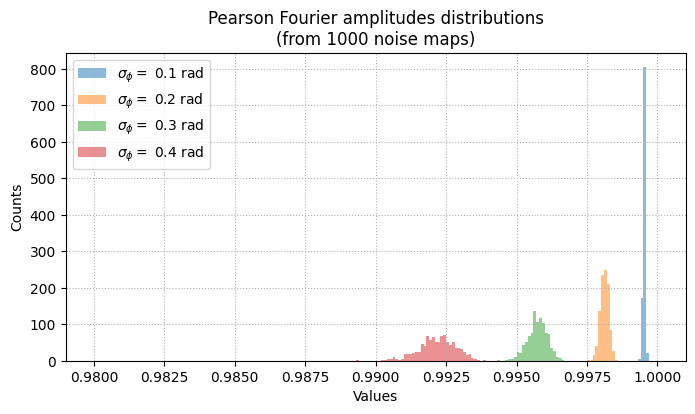

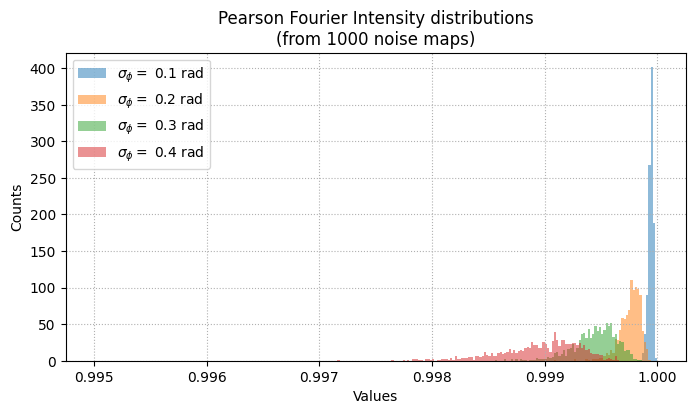

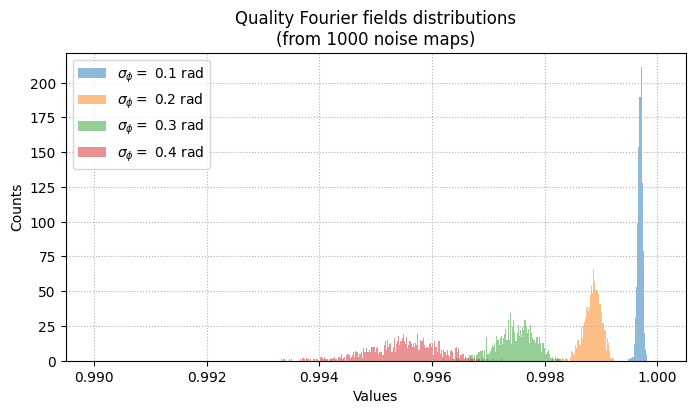

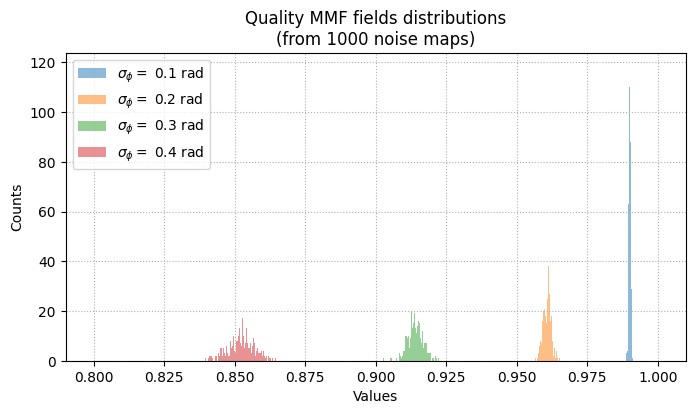

In [107]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.grid(ls=":")
axs.set_title(f"Pearson Fourier amplitudes distributions\n(from {noisy_fts.shape[-1]} noise maps)")
axs.set_xlabel("Values")
axs.set_ylabel("Counts")
for i in range(len(phase_noise_stds)):
    axs.hist(pearsons_ft[:, i], bins=np.arange(0.98, 1, 0.0001), ls='None', alpha=0.5, label=(r"$\sigma_{\phi} = $ " + f"{phase_noise_stds[i]:.1f} rad"))
axs.legend()
plt.savefig('pearsons_ft.svg')


fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.grid(ls=":")
axs.set_title(f"Pearson Fourier Intensity distributions\n(from {noisy_fts.shape[-1]} noise maps)")
axs.set_xlabel("Values")
axs.set_ylabel("Counts")
for i in range(len(phase_noise_stds)):
    axs.hist(pearsons_ft2[:, i], bins=np.arange(0.995, 1, 0.00002), ls='None', alpha=0.5, label=(r"$\sigma_{\phi} = $ " + f"{phase_noise_stds[i]:.1f} rad"))
axs.legend()
plt.savefig('pearsons_ft2.svg')

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.grid(ls=":")
axs.set_title(f"Quality Fourier fields distributions\n(from {noisy_fts.shape[-1]} noise maps)")
axs.set_xlabel("Values")
axs.set_ylabel("Counts")
for i in range(len(phase_noise_stds)):
    axs.hist(qualities_ft[:, i], bins=np.arange(0.99, 1, 0.00002), ls='None', alpha=0.5, label=(r"$\sigma_{\phi} = $ " + f"{phase_noise_stds[i]:.1f} rad"))
axs.legend()
plt.savefig('qualities_ft.svg')


fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.grid(ls=":")
axs.set_title(f"Quality MMF fields distributions\n(from {noisy_fts.shape[-1]} noise maps)")
axs.set_xlabel("Values")
axs.set_ylabel("Counts")
for i in range(len(phase_noise_stds)):
    axs.hist(qualities[:, i], bins=np.arange(0.8, 1, 0.0001), ls='None', alpha=0.5, label=(r"$\sigma_{\phi} = $ " + f"{phase_noise_stds[i]:.1f} rad"))
axs.legend()

plt.savefig('qualities.svg')